#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import re
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode, median
from scipy.stats import chi2

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
with open(project_dir + '/Thoth_Full_Run/position_dict.pkl', 'rb') as f:
    full_sample_position_dict = pickle.load(f)  
with open(project_dir + '/Thoth_Full_Run/variant_df.pkl', 'rb') as f:
    full_variant_df = pickle.load(f)   
with open(project_dir + '/gpi_variant_df.pkl', 'rb') as f:
    gpi_variant_df = pickle.load(f) 

In [4]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [5]:
with open(project_dir + '/Mutation_Counts/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    gpi_zero_and_non_zero_mutation_counts = pickle.load(f)     
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)   

In [6]:
genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');


C:\Users\nicho\AppData\Local\Temp/ipykernel_17512/796550937.py:1: DtypeWarning: Columns (1,3,13,14,15,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');


In [7]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

##### Plot p values for known CDS

In [8]:
annotation_cds_boundaries = []
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            annotation_cds_boundaries.append((a.get("locus_tag")[0], a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   

In [9]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_cds_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_cds_boundaries.sort(key = lambda x: x[2])

temp_cds = mycobrowser_df[mycobrowser_df['Feature'].isin(['CDS','rRNA','tRNA'])][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_all_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_all_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_all_boundaries.sort(key = lambda x: x[2])

In [10]:
min_intergenic_length = 50
mycobrowser_interregion_boundaries = []
max_stop = 0
for n,cds in enumerate(mycobrowser_all_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_all_boundaries) - 1:
        if mycobrowser_all_boundaries[n+1][2] > max_stop + min_intergenic_length:
            mycobrowser_interregion_boundaries.append((cds[0], cds[1], max_stop, mycobrowser_all_boundaries[n+1][2], cds[4], cds[5]))


In [11]:
p =sum([1 for x in full_sample_zero_and_non_zero_mutation_counts if x > 0])/(len(full_sequence) - len(compass_dict))
print(p)

In [11]:
def conf_interval(n):
    return math.sqrt(p*(1-p))/math.sqrt(n)

0.48730925587553936


In [14]:
intergenic_mutation_ave = []
for (locus, product, start, stop, strand, name) in mycobrowser_interregion_boundaries: 
    compass_overlap = 0
    mutation_counts = []
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
        else:
            mutation_counts.append(full_sample_zero_and_non_zero_mutation_counts[n])
    if compass_overlap / (stop - start) > 0.1:
        continue
    proportion_mutated_positions = sum([1 for m in mutation_counts if m>0])/len(mutation_counts)
    length = len(mutation_counts)
    num_sds = (proportion_mutated_positions - p)/conf_interval(length)
    if (abs(num_sds)> 4):
        locus_class = 'X'
    else:
        locus_class = 'N'
    intergenic_mutation_ave.append([locus, start, stop, strand, length, proportion_mutated_positions, num_sds])
    intergenic_mutation_ave.sort(key = lambda x:x[6])

<AxesSubplot:ylabel='Count'>

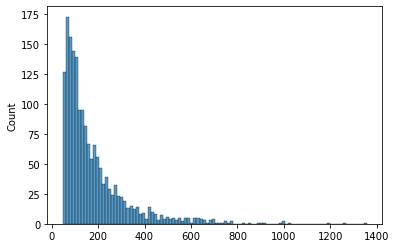

In [22]:
sns.histplot([x[4] for x in intergenic_mutation_ave], bins =100)

In [18]:
for i in intergenic_mutation_ave:
    print(i)

['Rv0887c', 985971, 987232, -1, 1261, 0.3647898493259318, -8.704270102102349]
['Rv1759c', 1992577, 1993152, -1, 533, 0.30393996247654786, -8.469546315805275]
['Rv0689c', 789411, 790023, -1, 612, 0.31699346405228757, -8.42947564838842]
['Rv3059', 3420970, 3421740, 1, 770, 0.33896103896103896, -8.235645125178873]
['Rv3053c', 3414958, 3415434, -1, 476, 0.3004201680672269, -8.157505062131897]
['Rv2351c', 2632075, 2632922, -1, 847, 0.358913813459268, -7.475861459851834]
['Rv1438', 1616349, 1616960, 1, 611, 0.3404255319148936, -7.263805574016572]
['Rv3089', 3457272, 3458210, 1, 903, 0.3698781838316722, -7.059872081760355]
['MTB000015', 1113583, 1114292, 1, 709, 0.35825105782792666, -6.875094087387915]
['Rv1758', 1989566, 1989832, 1, 266, 0.2781954887218045, -6.8232828616620065]
['Rv1051c', 1174700, 1175722, -1, 1022, 0.38258317025440314, -6.698078765850517]
['Rv1040c', 1163376, 1164571, -1, 1195, 0.3916317991631799, -6.617036136650471]
['Rv2957', 3310297, 3310713, 1, 416, 0.3269230769230769,

In [ ]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style(style='white')
sns.kdeplot(data = locus_mutation_ave_df, x= 'ave_mutation', hue = 'functional_category', common_norm= False,clip=(0.0, 1000000000.0))
plt.xscale('log')

In [ ]:
sns.histplot([x[11] for x in locus_mutation_ave], bins=100)

In [12]:
mycobrowser_interregion_boundaries

[('Rv0001',
  'Chromosomal replication initiator protein DnaA',
  1524,
  2051,
  1,
  'dnaA'),
 ('Rv0004', 'Conserved hypothetical protein', 4997, 5239, 1, 'Rv0004'),
 ('Rv0006',
  'DNA gyrase (subunit A) GyrA (DNA topoisomerase (ATP-hydrolysing)) (DNA topoisomerase II) (type II DNA topoisomerase)',
  9818,
  9913,
  1,
  'gyrA'),
 ('Rv0007', 'Possible conserved membrane protein', 10828, 10886, 1, 'Rv0007'),
 ('MTB000001', 'tRNA-Ile (GAT)', 10960, 11111, 1, 'ileT'),
 ('MTB000002', 'tRNA-Ala (TGC)', 11184, 11873, 1, 'alaT'),
 ('Rv0008c', 'Possible membrane protein', 12311, 12467, -1, 'Rv0008c'),
 ('Rv0009',
  'Probable iron-regulated peptidyl-prolyl cis-trans isomerase A PpiA (PPIase A) (rotamase A)',
  13016,
  13132,
  1,
  'ppiA'),
 ('Rv0010c',
  'Probable conserved membrane protein',
  13558,
  13713,
  -1,
  'Rv0010c'),
 ('Rv0011c',
  'Probable conserved transmembrane protein',
  13995,
  14088,
  -1,
  'Rv0011c'),
 ('Rv0018c',
  'Phosphoserine/threonine phosphatase PstP',
  23181